<a href="https://colab.research.google.com/github/dimakpa/DL_Projects/blob/main/ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Подготовка датасета

Первым делом создадим датасет из кинопетель, взяв каждую 5 картинку


In [146]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pathlib import Path

# specify GPU
device = torch.device("cuda")

In [147]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
df = pd.DataFrame(pd.read_excel("/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/data/classes.xlsx"))

df.head()

,№,"Узел ЩЖ, TIRADS"
0,178,4
1,179,5
2,180,3
3,181,5
4,182,3


Для удобства поменяем тирадс на 0 и 1

In [149]:
# df.loc[df['Узел ЩЖ, TIRADS'] < 5, 'Узел ЩЖ, TIRADS'] = 0
# df.loc[df['Узел ЩЖ, TIRADS'] > 4, 'Узел ЩЖ, TIRADS'] = 1
# df.head()

Напишем функцию, которая достает каждое пятое изображение из кинопетли

In [150]:
from PIL import Image
im = Image.open('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/data/178/178_TIRADS4_long.tif')
im.show()

In [151]:
im.n_frames

121

In [152]:
def parse_tif(filePath, fileSave, numOfBlock):
    if Path(filePath).is_file():
      img = Image.open(filePath)
      numFramesPerTif = img.n_frames
      for i in range (numFramesPerTif):
          if i%5 == 0:
              try:
                  img.seek(i)
                  img.save(fileSave + numOfBlock +'Block_%s.jpg'%(i,))
              except EOFError: #end of file error
                  print('End of file error')


In [153]:
# parse_tif('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/data/178/178_TIRADS4_long.tif', '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/data', '2228' )

Теперь извлечем каждое пятое фото из всех кинопетель и сохраним в отедльных папках для бинарной классификации.

0 - в одной
1 - в другой

Поменяем имена столбцов для удобства

In [154]:
df = df.rename(columns={'№': 'id', 'Узел ЩЖ, TIRADS': 'predict'})

In [155]:
zero_df = df[df['predict'] < 5]
one_df = df[df['predict'] == 5]

zero_df.head()

,id,predict
0,178,4
2,180,3
4,182,3
10,188,3
11,189,4


In [156]:
save_path0 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/train_data_jpg/zero/'
for index, row in zero_df.iterrows ():
  parse_tif('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/data/' + str(row['id']) + '/' + str(row['id']) + '_TIRADS' + str(row['predict']) + '_cross.tif', save_path0, str(row['id']) )
  parse_tif('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/data/' + str(row['id']) + '/' + str(row['id']) + '_TIRADS' + str(row['predict']) + '_long.tif', save_path0, str(row['id']) )
#  print(row['predict'])


In [157]:
save_path1 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/train_data_jpg/one/'
for index, row in one_df.iterrows ():
  parse_tif('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/data/' + str(row['id']) + '/' + str(row['id']) + '_TIRADS' + str(row['predict']) + '_cross.tif', save_path1, str(row['id']) )
  parse_tif('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/data/' + str(row['id']) + '/' + str(row['id']) + '_TIRADS' + str(row['predict']) + '_long.tif', save_path1, str(row['id']) )

Разделим теперь на тренировочную и тестовую выборки

In [158]:
pip install split-folders

In [159]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/train_data_jpg', output="/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output", seed=1337, ratio=(.7, 0.15,0.15))


Copying files: 841 files [00:16, 49.62 files/s]


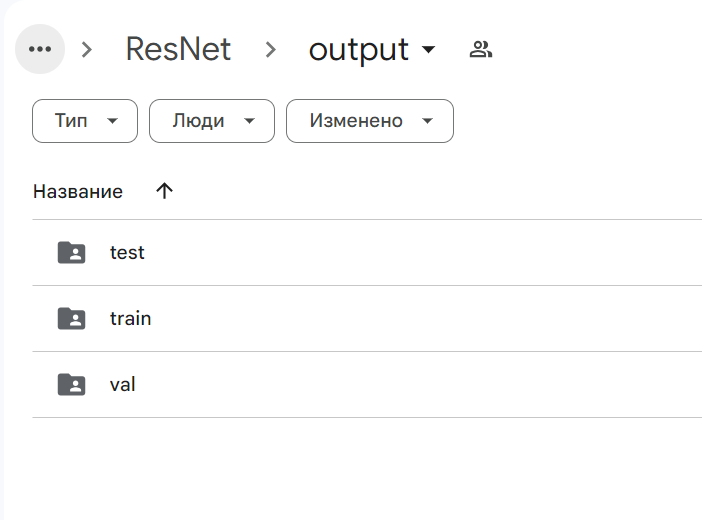

Данные готовы к обучению

#Подготовка модели

In [160]:
import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import transforms


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Создадим трансфермер для данных

Вращать картинки смысла нет

In [161]:
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Создадим датасет

In [162]:
TRAIN_ROOT = "/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/train"
TEST_ROOT = "/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/test"
VAL_ROOT = "/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/val"

train_ds = ImageFolder(TRAIN_ROOT, transform=tfm)
test_ds = ImageFolder(TEST_ROOT, transform=tfm)
val_ds = ImageFolder(VAL_ROOT, transform=tfm)

Посмотрим на данные

In [163]:
LEN_TRAIN = len(train_ds)
LEN_TEST = len(test_ds)
LEN_VAL = len(val_ds)
print(f'Len of Train: {LEN_TRAIN} , Len of Test: {LEN_TEST} , Len of val: {LEN_VAL}')

print(train_ds.class_to_idx)

Len of Train: 587 , Len of Test: 128 , Len of val: 126
{'one': 0, 'zero': 1}


Создадим загрузчик данных батчами

In [164]:
train_loader = DataLoader(train_ds, batch_size = 30, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=30, shuffle = True)
val_loader = DataLoader(val_ds, batch_size=30, shuffle = True)

Создадим модель ResNet-18

In [165]:
model = resnet18(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Заменим выходной линейных слой, чтоб на вызоде было 2 фичи

In [166]:
model.fc = Linear(in_features=512, out_features=2)
model = model.to(device)
# model = model.cuda()

Зададим оптимизатор и лосс функцию

In [167]:
optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

loss_fn = CrossEntropyLoss()

#Приступим к тренировке модели

In [168]:
EPOSH = 7
validation_accuracy = []
train_losses = []
epoch_list = []

In [169]:
for epoch in range(EPOSH):
    epoch+=1
    epoch_list.append(epoch)
    start = time()

    tr_acc = 0
    val_acc = 0

    # Train
    model.train()

    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()

            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()

            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimiser.step()

            # training ends

            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))

        ep_tr_acc = tr_acc / LEN_TRAIN

    # Evaluate
    model.eval()
    with torch.no_grad():
        for xval, yval in val_loader:
            xval = xval.to(device)
            val_prob = model(xval)
            val_prob = val_prob.cpu()

            val_pred = torch.max(val_prob,1).indices
            val_acc += int(torch.sum(val_pred == yval))

        ep_val_acc = val_acc / LEN_VAL

    end = time()
    duration = (end - start) / 60
    train_losses.append(loss)
    validation_accuracy.append(ep_val_acc)

    print(f"Epoch: {epoch}, Time: {duration}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Val_acc: {ep_val_acc}")

100%|██████████| 20/20 [03:04<00:00,  9.25s/batch]


Epoch: 1, Time: 3.3117777903874717, Loss: 0.3739689886569977
Train_acc: 0.7989778534923339, Val_acc: 0.6825396825396826


100%|██████████| 20/20 [02:48<00:00,  8.41s/batch]


Epoch: 2, Time: 3.0050453186035155, Loss: 0.20414723455905914
Train_acc: 0.9437819420783645, Val_acc: 0.9523809523809523


100%|██████████| 20/20 [02:52<00:00,  8.60s/batch]


Epoch: 3, Time: 3.072029542922974, Loss: 0.006867370568215847
Train_acc: 0.9846678023850085, Val_acc: 0.7222222222222222


100%|██████████| 20/20 [02:45<00:00,  8.29s/batch]


Epoch: 4, Time: 2.9574515581130982, Loss: 0.27597594261169434
Train_acc: 0.9948892674616695, Val_acc: 0.9682539682539683


100%|██████████| 20/20 [02:46<00:00,  8.31s/batch]


Epoch: 5, Time: 2.9795005400975545, Loss: 0.0051313526928424835
Train_acc: 0.9880749574105622, Val_acc: 0.9523809523809523


100%|██████████| 20/20 [02:42<00:00,  8.15s/batch]


Epoch: 6, Time: 2.9112398862838744, Loss: 0.09420754015445709
Train_acc: 0.9880749574105622, Val_acc: 0.9761904761904762


100%|██████████| 20/20 [02:47<00:00,  8.35s/batch]


Epoch: 7, Time: 2.979921527703603, Loss: 0.001103908522054553
Train_acc: 0.9914821124361158, Val_acc: 0.8571428571428571


#Проверка на тестовой выборке

In [170]:
for x, y in test_loader:
  x, y
  break
x.shape, y.shape

(torch.Size([30, 3, 224, 224]), torch.Size([30]))

In [204]:
loss_test = []
test_acc = 0
batches = 0


model.eval()
with torch.no_grad():
    for xtest, ytest in test_loader:
        batches+=1
        xtest = xtest.to(device)
        test_prob = model(xtest)
        test_prob = test_prob.cpu()

        loss = loss_fn(test_prob, ytest)
        loss_test.append(loss)

        test_pred = torch.max(test_prob,1).indices
        print(int(torch.sum(test_pred == ytest)))
        test_acc += int(torch.sum(test_pred == ytest))

    ep_test_acc = test_acc / LEN_TEST

batches_list = [i for i in range(1, batches+1)]

print(f"Test_acc: {ep_test_acc}")

28
23
24
24
4
Test_acc: 0.8046875


In [172]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

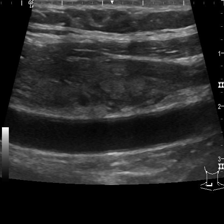

In [173]:
from PIL import Image

img = pil_loader('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/test/one/179Block_5.jpg')
display(img.resize((224, 224)))
# img_array = np.array(img)
img_tensor = tfm(img)

Проверим с обычными избражениями

In [177]:
sample_1 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/test/one/179Block_5.jpg'
sample_2 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/test/one/186Block_115.jpg'
sample_3 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/test/zero/193Block_65.jpg'
sample_4 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/test/zero/199Block_30.jpg'

sample_list = [sample_1,sample_2,sample_3,sample_4]

In [202]:
test_loader.batch_size

30

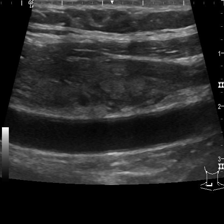

Model prediction 0, 0


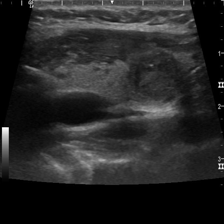

Model prediction 0, 0


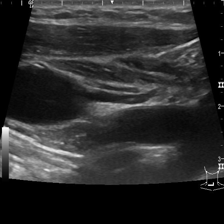

Model prediction 1, 1


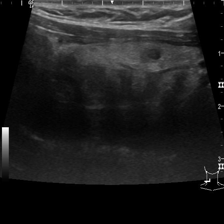

Model prediction 1, 1


In [179]:
from PIL import Image
import numpy as np

for image_path in sample_list:
    img = pil_loader(image_path)
    display(img.resize((224,224)))
    img_tensor = tfm(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    if pred == 1:
        print(f"Model prediction {pred}, 1")
    else:
        print(f"Model prediction {pred}, 0")

    print("========================================================")

#ГРАФИКИ

In [193]:
train_losses[0].detach().numpy().astype(float).item()

0.3739689886569977

In [188]:
validation_accuracy

[0.6825396825396826,
 0.9523809523809523,
 0.7222222222222222,
 0.9682539682539683,
 0.9523809523809523,
 0.9761904761904762,
 0.8571428571428571]

In [198]:
# ls = []
# for i in train_losses:
#   ls.append(i.detach().numpy().astype(float).item())
# train_losses = ls

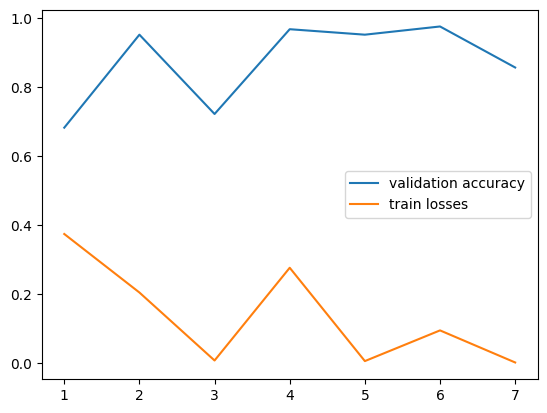

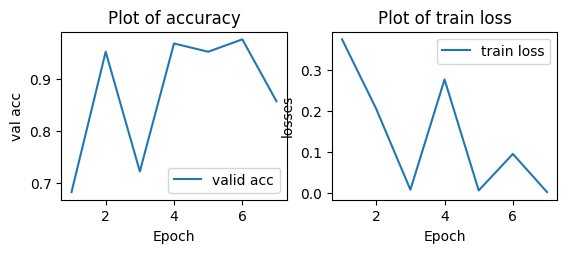

In [206]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.plot(epoch_list, validation_accuracy, label='validation accuracy')
plt.plot(epoch_list, train_losses, label='train losses')
plt.legend()


x_data1 = epoch_list
y_data1 = validation_accuracy

x_data2 = epoch_list
y_data2 = train_losses

fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax1.plot(x_data1, y_data1, label='valid acc')
ax2.plot(x_data2, y_data2, label='train loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('val acc')
ax1.set_title('Plot of accuracy')
ax1.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('losses')
ax2.set_title('Plot of train loss')
ax2.legend()

plt.show()

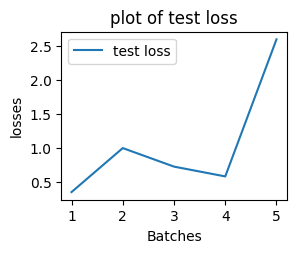

In [205]:
x_data2 = batches_list
y_data2 = loss_test

fig = plt.figure()
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(x_data2, y_data2, label='test loss')
ax2.set_xlabel('Batches')
ax2.set_ylabel('losses')
ax2.set_title('plot of test loss')
ax2.legend()

plt.show()

В Последнем батче большая ошибка, потому что батч неполный